In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import dataloader
import modules 
import plots
from trainer import Trainer
import torch 
import matplotlib.pyplot as plt
from matplotlib_style import setup_matplotlib_environment, theme_categorical_bright

In [3]:
setup_matplotlib_environment()

# Test on Kaggle Housing Dataset

In [4]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(dataloader.KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

def k_fold(trainer, data, network_architecture, k, lr):
    models, data_folds = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = modules.LinearReLUMLP(network_architecture, learning_rate=0.01)
        trainer.fit(model, data_fold)
        models.append(model)
        data_folds.append(data_fold)
    return models, data_folds

In [8]:
data = dataloader.KaggleHouse(batch_size=64, )
data.preprocess()

In [9]:
network_architecture = [32, 32]
model = modules.LinearReLUMLP(network_architecture, learning_rate=0.01)

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
trainer = Trainer(max_epochs=50)
trainer.fit(model, data)

Model running on cpu

 EPOCH 

Epoch 1/50, Training Loss: 42.8967

 EPOCH 

Epoch 2/50, Training Loss: 2.1898

 EPOCH 

Epoch 3/50, Training Loss: 0.2308

 EPOCH 

Epoch 4/50, Training Loss: 0.0542

 EPOCH 

Epoch 5/50, Training Loss: 0.0305

 EPOCH 

Epoch 6/50, Training Loss: 0.0221

 EPOCH 

Epoch 7/50, Training Loss: 0.0177

 EPOCH 

Epoch 8/50, Training Loss: 0.0159

 EPOCH 

Epoch 9/50, Training Loss: 0.0139

 EPOCH 

Epoch 10/50, Training Loss: 0.0128

 EPOCH 

Epoch 11/50, Training Loss: 0.0124

 EPOCH 

Epoch 12/50, Training Loss: 0.0124

 EPOCH 

Epoch 13/50, Training Loss: 0.0116

 EPOCH 

Epoch 14/50, Training Loss: 0.0113

 EPOCH 

Epoch 15/50, Training Loss: 0.0109

 EPOCH 

Epoch 16/50, Training Loss: 0.0115

 EPOCH 

Epoch 17/50, Training Loss: 0.0116

 EPOCH 

Epoch 18/50, Training Loss: 0.0115

 EPOCH 

Epoch 19/50, Training Loss: 0.0117

 EPOCH 

Epoch 20/50, Training Loss: 0.0112

 EPOCH 

Epoch 21/50, Training Loss: 0.0119

 EPOCH 

Epoch 22/50, Training Loss: 0.01

In [6]:

y = torch.tensor(data.train["SalePrice"].values.astype(float), dtype=torch.float32)
y_hat = torch.exp(model(torch.tensor(data.train.drop(columns="SalePrice").values.astype(float), dtype=torch.float32)))

fig, ax = plt.subplots(ncols=1, nrows=1)

ax.scatter(y.detach().numpy(), y_hat.detach().numpy(), alpha=0.6, label='Predicted')

# add a line
ax.plot([min(y), max(y)], [min(y), max(y)], color='red', label='Real')


NameError: name 'data' is not defined

In [22]:
models, data_folds = k_fold(trainer, data, network_architecture=[32, 32], k=5, lr=0.1)

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Model running on cpu

 EPOCH 

Epoch 1/50, Training Loss: 51.9689
Epoch 1/50, Validation Loss: 2.6753

 EPOCH 

Epoch 2/50, Training Loss: 3.8008
Epoch 2/50, Validation Loss: 0.1581

 EPOCH 

Epoch 3/50, Training Loss: 0.5317
Epoch 3/50, Validation Loss: 0.0789

 EPOCH 

Epoch 4/50, Training Loss: 0.1368
Epoch 4/50, Validation Loss: 0.0845

 EPOCH 

Epoch 5/50, Training Loss: 0.0571
Epoch 5/50, Validation Loss: 0.0542

 EPOCH 

Epoch 6/50, Training Loss: 0.0270
Epoch 6/50, Validation Loss: 0.0297

 EPOCH 

Epoch 7/50, Training Loss: 0.0209
Epoch 7/50, Validation Loss: 0.0238

 EPOCH 

Epoch 8/50, Training Loss: 0.0183
Epoch 8/50, Validation Loss: 0.0251

 EPOCH 

Epoch 9/50, Training Loss: 0.0161
Epoch 9/50, Validation Loss: 0.0198

 EPOCH 

Epoch 10/50, Training Loss: 0.0143
Epoch 10/50, Validation Loss: 0.0183

 EPOCH 

Epoch 11/50, Training Loss: 0.0127
Epoch 11/50, Validation Loss: 0.0206

 EPOCH 

Epoch 12/50, Training Loss: 0.0136
Epoch 12/50, Validation Loss: 0.0208

 EPOCH 

Ep

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 3/50, Training Loss: 0.5956
Epoch 3/50, Validation Loss: 0.2556

 EPOCH 

Epoch 4/50, Training Loss: 0.1182
Epoch 4/50, Validation Loss: 0.0664

 EPOCH 

Epoch 5/50, Training Loss: 0.0465
Epoch 5/50, Validation Loss: 0.0412

 EPOCH 

Epoch 6/50, Training Loss: 0.0282
Epoch 6/50, Validation Loss: 0.0333

 EPOCH 

Epoch 7/50, Training Loss: 0.0215
Epoch 7/50, Validation Loss: 0.0301

 EPOCH 

Epoch 8/50, Training Loss: 0.0173
Epoch 8/50, Validation Loss: 0.0294

 EPOCH 

Epoch 9/50, Training Loss: 0.0162
Epoch 9/50, Validation Loss: 0.0292

 EPOCH 

Epoch 10/50, Training Loss: 0.0153
Epoch 10/50, Validation Loss: 0.0271

 EPOCH 

Epoch 11/50, Training Loss: 0.0132
Epoch 11/50, Validation Loss: 0.0272

 EPOCH 

Epoch 12/50, Training Loss: 0.0122
Epoch 12/50, Validation Loss: 0.0273

 EPOCH 

Epoch 13/50, Training Loss: 0.0125
Epoch 13/50, Validation Loss: 0.0267

 EPOCH 

Epoch 14/50, Training Loss: 0.0118
Epoch 14/50, Validation Loss: 0.0287

 EPOCH 

Epoch 15/50, Training Loss: 0.

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 2/50, Training Loss: 3.9361
Epoch 2/50, Validation Loss: 0.2928

 EPOCH 

Epoch 3/50, Training Loss: 0.5795
Epoch 3/50, Validation Loss: 0.1229

 EPOCH 

Epoch 4/50, Training Loss: 0.1385
Epoch 4/50, Validation Loss: 0.1006

 EPOCH 

Epoch 5/50, Training Loss: 0.0567
Epoch 5/50, Validation Loss: 0.0382

 EPOCH 

Epoch 6/50, Training Loss: 0.0265
Epoch 6/50, Validation Loss: 0.0292

 EPOCH 

Epoch 7/50, Training Loss: 0.0234
Epoch 7/50, Validation Loss: 0.0263

 EPOCH 

Epoch 8/50, Training Loss: 0.0197
Epoch 8/50, Validation Loss: 0.0253

 EPOCH 

Epoch 9/50, Training Loss: 0.0192
Epoch 9/50, Validation Loss: 0.0293

 EPOCH 

Epoch 10/50, Training Loss: 0.0166
Epoch 10/50, Validation Loss: 0.0233

 EPOCH 

Epoch 11/50, Training Loss: 0.0143
Epoch 11/50, Validation Loss: 0.0224

 EPOCH 

Epoch 12/50, Training Loss: 0.0138
Epoch 12/50, Validation Loss: 0.0223

 EPOCH 

Epoch 13/50, Training Loss: 0.0119
Epoch 13/50, Validation Loss: 0.0218

 EPOCH 

Epoch 14/50, Training Loss: 0.01

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 1/50, Training Loss: 48.5994
Epoch 1/50, Validation Loss: 9.3989

 EPOCH 

Epoch 2/50, Training Loss: 4.2009
Epoch 2/50, Validation Loss: 1.3552

 EPOCH 

Epoch 3/50, Training Loss: 0.6422
Epoch 3/50, Validation Loss: 0.3172

 EPOCH 

Epoch 4/50, Training Loss: 0.1380
Epoch 4/50, Validation Loss: 0.0487

 EPOCH 

Epoch 5/50, Training Loss: 0.0456
Epoch 5/50, Validation Loss: 0.0329

 EPOCH 

Epoch 6/50, Training Loss: 0.0272
Epoch 6/50, Validation Loss: 0.0216

 EPOCH 

Epoch 7/50, Training Loss: 0.0195
Epoch 7/50, Validation Loss: 0.0191

 EPOCH 

Epoch 8/50, Training Loss: 0.0224
Epoch 8/50, Validation Loss: 0.0189

 EPOCH 

Epoch 9/50, Training Loss: 0.0211
Epoch 9/50, Validation Loss: 0.0171

 EPOCH 

Epoch 10/50, Training Loss: 0.0145
Epoch 10/50, Validation Loss: 0.0145

 EPOCH 

Epoch 11/50, Training Loss: 0.0126
Epoch 11/50, Validation Loss: 0.0132

 EPOCH 

Epoch 12/50, Training Loss: 0.0127
Epoch 12/50, Validation Loss: 0.0145

 EPOCH 

Epoch 13/50, Training Loss: 0.011

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 2/50, Validation Loss: 1.7794

 EPOCH 

Epoch 3/50, Training Loss: 0.6070
Epoch 3/50, Validation Loss: 0.3869

 EPOCH 

Epoch 4/50, Training Loss: 0.1127
Epoch 4/50, Validation Loss: 0.1359

 EPOCH 

Epoch 5/50, Training Loss: 0.0490
Epoch 5/50, Validation Loss: 0.1025

 EPOCH 

Epoch 6/50, Training Loss: 0.0304
Epoch 6/50, Validation Loss: 0.0875

 EPOCH 

Epoch 7/50, Training Loss: 0.0229
Epoch 7/50, Validation Loss: 0.0788

 EPOCH 

Epoch 8/50, Training Loss: 0.0190
Epoch 8/50, Validation Loss: 0.0729

 EPOCH 

Epoch 9/50, Training Loss: 0.0163
Epoch 9/50, Validation Loss: 0.0653

 EPOCH 

Epoch 10/50, Training Loss: 0.0144
Epoch 10/50, Validation Loss: 0.0598

 EPOCH 

Epoch 11/50, Training Loss: 0.0136
Epoch 11/50, Validation Loss: 0.0570

 EPOCH 

Epoch 12/50, Training Loss: 0.0126
Epoch 12/50, Validation Loss: 0.0559

 EPOCH 

Epoch 13/50, Training Loss: 0.0124
Epoch 13/50, Validation Loss: 0.0550

 EPOCH 

Epoch 14/50, Training Loss: 0.0123
Epoch 14/50, Validation Loss: 0

In [54]:
k_fold_y = []
k_fold_y_hat = []

for i, (model, data_fold) in enumerate(zip(models, data_folds)):
    y = torch.tensor(data_fold.val["SalePrice"].values.astype(float), dtype=torch.float32)
    y_hat = torch.exp(model(torch.tensor(data_fold.val.drop(columns="SalePrice").values.astype(float), dtype=torch.float32)))

    k_fold_y.append(y.detach().numpy())
    k_fold_y_hat.append(y_hat.detach().numpy())

In [55]:
print(len(k_fold_y), len(k_fold_y_hat))

5 5


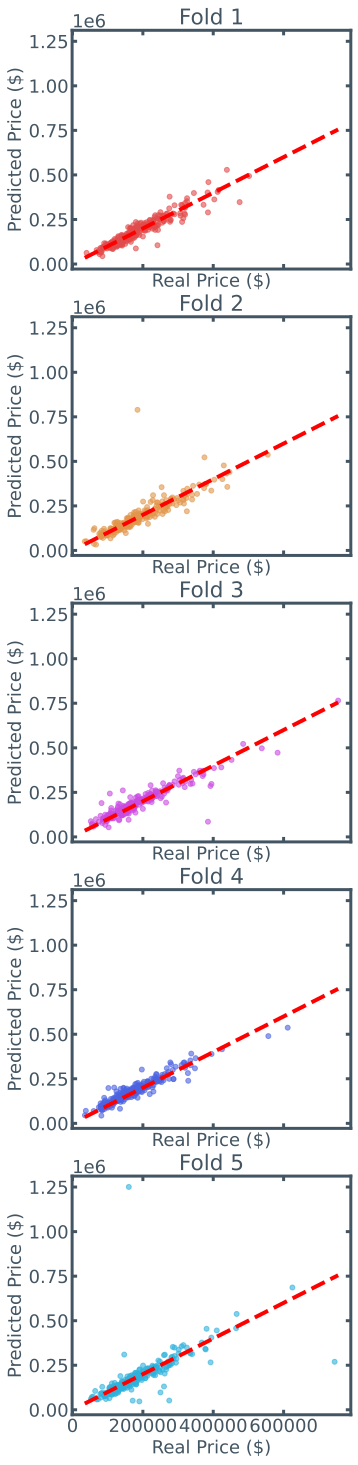

In [69]:
fig, ax = plt.subplots(ncols=1, nrows=len(k_fold_y), figsize=(5, 5 * len(k_fold_y)), sharex=True, sharey=True)


for i in range(len(k_fold_y)):
    ax[i].scatter(k_fold_y[i], k_fold_y_hat[i], alpha=0.6, marker='.', c=theme_categorical_bright[i], label='Predicted')
    ax[i].plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='dashed', label='Real')
    ax[i].set_title(f'Fold {i+1}')
    ax[i].set_ylabel('Predicted Price ($)')
    ax[i].set_xlabel('Real Price ($)')
# add a line
